In [679]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import rasterio
import pyvista as pv


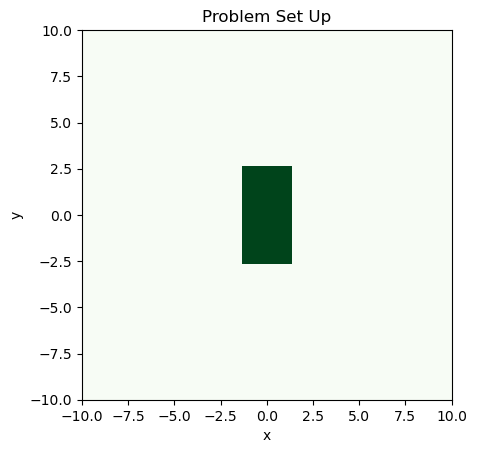

In [680]:
n = 30
grid_size = 10

x, delta = np.linspace(-grid_size, grid_size, n, retstep=True)
y = np.linspace(-grid_size, grid_size, n)
X,Y = np.meshgrid(x,y)
Z = 0.5


wind_velocity_x = 1
wind_velocity_y = 0.1

U = np.ones_like(X)*wind_velocity_x
V = np.ones_like(Y)*wind_velocity_y


#specify the building dimensions, this will be converted to a 2D elevation array
height = 3
L, W = 3,6

building_pos_x = 0
building_pos_y = 0
building_pos_z = 0

building_pos_x_idx = n//2
building_pos_y_idx = n//2

L_units = int(L//delta)
W_units = int(W//delta)

elevation = np.zeros_like(X)
elevation[building_pos_x_idx-W_units//2 : building_pos_x_idx + W_units//2, building_pos_y_idx-L_units//2 : building_pos_y_idx + L_units//2] = height

# elevation[building_pos_x_idx : building_pos_x_idx + W_units, building_pos_y_idx : building_pos_y_idx + L_units] = height

plt.imshow(elevation,cmap='Greens', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.title('Problem Set Up')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



In [681]:
def rotate_and_shift(grid, theta, shift_x, shift_y):
    rows, cols = grid.shape
    center = np.array([cols // 2, rows // 2])

    # Get coordinates of all True values
    true_coords = np.argwhere(grid)
    if len(true_coords) == 0:
        return [], grid

    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)],
    ])


    # Rotate the coordinates around the grid center
    rotated_coords = []
    for coord in true_coords:
        coord_shifted = coord - center  # Shift to the center
        rotated_coord = rotation_matrix @ coord_shifted  # Apply rotation
        rotated_coords.append(rotated_coord + center)  # Shift back

    rotated_coords = np.array(rotated_coords)

    # Shift the coordinates up and to the right
    shifted_coords = rotated_coords + np.array([shift_y, shift_x])

    shifted_coords = np.round(shifted_coords)
    shifted_coords = np.array(shifted_coords, dtype=int)
    # Create a new grid
    transformed_grid = np.zeros_like(grid, dtype=bool)

    # Map shifted coordinates back to the grid
    for coord in shifted_coords:
        x, y = int(round(coord[0])), int(round(coord[1]))
        if 0 <= x < rows and 0 <= y < cols:  # Ensure within bounds
            transformed_grid[x, y] = True

    return shifted_coords, transformed_grid

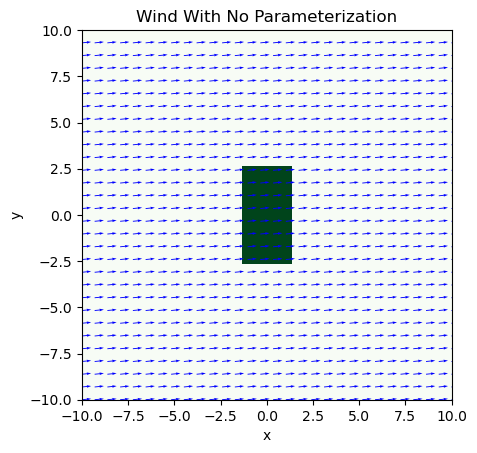

In [682]:
# make windflow 0 in the building zone
# U[building_pos_x_idx-W_units//2 : building_pos_x_idx + W_units//2, building_pos_y_idx-L_units//2 : building_pos_y_idx + L_units//2] = 0
# V[building_pos_x_idx-W_units//2 : building_pos_x_idx + W_units//2, building_pos_y_idx-L_units//2 : building_pos_y_idx + L_units//2] = 0

plt.quiver(X, Y, U, V, scale=40, color='blue')
plt.imshow(elevation,cmap='Greens', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.xlabel('x')
plt.ylabel('y')
plt.title("Wind With No Parameterization")
plt.show()


## Displacement Zones

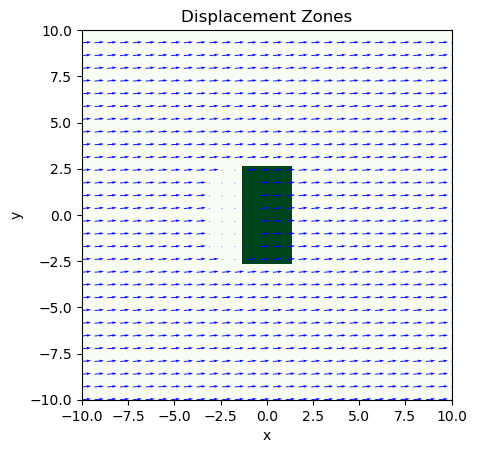

In [683]:
# calculate variables phi, L_f, 
x_pos, y_pos = -2,0
phi = math.acos(wind_velocity_x / np.sqrt(wind_velocity_x**2 + wind_velocity_y**2))

L_f = (2 * W) / (1 + (0.8 * (W/height)))

# calculate half-axis values
XA_x = L_f * np.sin(phi)**2 * np.sqrt(1 - (Z/(0.6*height))**2)*5
XA_y = 0.5 * W


YA_x = 0.5 * L
YA_y = L_f * np.cos(phi)**2 * np.sqrt(1 - (Z/(0.6*height))**2)/1.5

#displacement zone 1
displacement_x = np.square((X-x_pos)/XA_x) + np.square((Y-y_pos)/XA_y)
mask_displacement_x = displacement_x <= 1

U[mask_displacement_x] = 0
V[mask_displacement_x] = 0

#displacement zone 2
displacement_y = np.square((X - x_pos)/YA_x) + np.square((Y - y_pos)/YA_y)
mask_displacement_y = displacement_y <= 1

U[mask_displacement_y] = 0#displacement_y[mask_displacement_y]
V[mask_displacement_y] = 0#displacement_y[mask_displacement_y]

plt.quiver(X, Y, U, V, scale=40, color='blue')
plt.imshow(elevation,cmap='Greens', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Displacement Zones')
plt.show()

## Set up For Cavity and Wake Zones

In [684]:
# Calculate W_eff and L_eff

# calcualte W_eff and L_eff by rotating the building
theta = -math.acos(wind_velocity_x / (np.sqrt(wind_velocity_x**2 + wind_velocity_y**2)))

rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

rotated_W = rotation_matrix @ np.array([0,W])
W_eff = rotated_W[0]
rotated_L = rotation_matrix @ np.array([L,0])
L_eff = rotated_L[0]

phi = math.acos(wind_velocity_x / (np.sqrt(wind_velocity_x**2 + wind_velocity_y**2)))

L_f = (2 * W_eff) / (1 + (0.8 * (W_eff/height)))
L_r = (1.8*W) / (((L/height)**0.3) * (1 + 0.24*W/height))



d_l = np.sqrt(np.square(np.abs(X - (building_pos_x+ L//2))) + np.square(np.abs(Y - (building_pos_y+W//2))))


U_H = wind_velocity_x
V_H = wind_velocity_y

U_Z = wind_velocity_x
V_Z = wind_velocity_y





## Wake Zone

In [685]:
A_x = 3*L_r * np.sqrt(1 - np.square(Z/height))
A_y = 0.5 * W


circle = lambda x: np.sqrt(A_y**2 - ((x*A_y)/(A_x)**2))

wake = np.square(X/A_x) + np.square(Y/A_y)


mask1 = wake <= 1
mask2 = X >= 0

wake_mask = mask1 * mask2

units = int(np.round(X.shape[0]/np.max(X)))

# U_wake = U_Z * np.power(1 - (d_N/X), 1.5)
# V_wake = V_Z * np.power(1 - (d_N/X), 1.5)

U_wake = wind_velocity_x * (X/(3*L_r))
V_wake = wind_velocity_y * np.ones_like(V)

original_coords = np.argwhere(wake_mask)
U_values = U_wake[original_coords[:, 0], original_coords[:, 1]]
V_values = V_wake[original_coords[:, 0], original_coords[:, 1]]

shift_x = L/2

shifted_coords, wake_mask = rotate_and_shift(wake_mask, theta, shift_x, 0)
# shifted_coords, wake_mask = rotate_and_shift(wake_mask, 0, 0, 0)


# the new coordinates might be out of index. Get rid of these
out_of_bounds = np.where(shifted_coords[:, 1] >= n)
shifted_coords = np.delete(shifted_coords, out_of_bounds, axis=0)
U_values = np.delete(U_values, out_of_bounds, axis=0)
V_values = np.delete(V_values, out_of_bounds, axis=0)

U[shifted_coords[:, 0], shifted_coords[: ,1]] = U_values
V[shifted_coords[:, 0], shifted_coords[:, 1]] = V_values



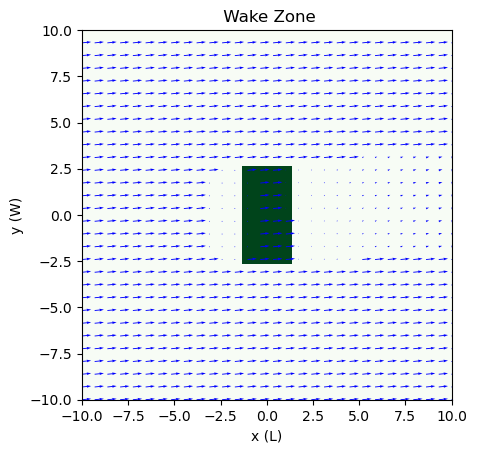

In [686]:
plt.quiver(X, Y, U, V, scale=40, color='blue')
plt.imshow(elevation,cmap='Greens', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])

plt.xlabel('x (L)')
plt.ylabel('y (W)')
plt.title(' Wake Zone')
plt.show()

## Cavity Zone

In [687]:
A_x = L_r * np.sqrt(1 - np.square(Z/height))
A_y = 0.5 * W

cavity = np.square((X)/A_x) + np.square((Y)/A_y)

mask1 = cavity <= 1
mask2 = X>=0
mask3 = Y>=0

cavity_mask_positive = mask1 * mask2 * mask3

x_0 = L_r/3
y_0_positive = W/4

U_cavity_positive = wind_velocity_x*(Y - y_0_positive)
V_cavity_positive = wind_velocity_y*(x_0 - X)*Y


mask4 = Y <= 0
cavity_mask_negative = mask1 * mask2 * mask4



y_0_negative = -W/4
U_cavity_negative = -wind_velocity_x* (Y - y_0_negative)
V_cavity_negative = wind_velocity_y* (x_0 - X)*Y

shift_x = L/2
# positive rotation
original_pos_coords = np.argwhere(cavity_mask_positive)
U_positive_values = U_cavity_positive[original_pos_coords[:, 0], original_pos_coords[:, 1]]
V_positive_values = V_cavity_positive[original_pos_coords[:, 0], original_pos_coords[:, 1]]

shifted_pos_coords, _ = rotate_and_shift(cavity_mask_positive, theta, shift_x, 0)
U[shifted_pos_coords[:, 0], shifted_pos_coords[: ,1]] = U_positive_values
V[shifted_pos_coords[:, 0], shifted_pos_coords[:, 1]] = V_positive_values

# negative rotation
original_neg_coords = np.argwhere(cavity_mask_negative)
U_negative_values = U_cavity_negative[original_neg_coords[:, 0], original_neg_coords[:, 1]]
V_negative_values = V_cavity_negative[original_neg_coords[:, 0], original_neg_coords[:, 1]]

shifted_neg_coords, _ = rotate_and_shift(cavity_mask_negative, theta, shift_x, 0)
U[shifted_neg_coords[:, 0], shifted_neg_coords[: ,1]] = U_negative_values
V[shifted_neg_coords[:, 0], shifted_neg_coords[:, 1]] = V_negative_values


# make windflow 0 in the building zone
U[building_pos_x_idx-W_units//2 : building_pos_x_idx + W_units//2, building_pos_y_idx-L_units//2 : building_pos_y_idx + L_units//2] = wind_velocity_x
V[building_pos_x_idx-W_units//2 : building_pos_x_idx + W_units//2, building_pos_y_idx-L_units//2 : building_pos_y_idx + L_units//2] = wind_velocity_y


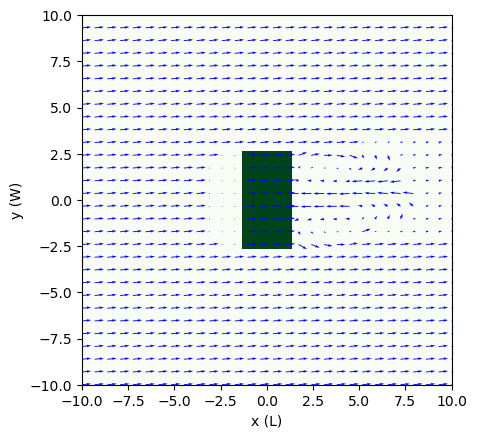

In [688]:
plt.quiver(X, Y, U, V, scale=40, color='blue')

plt.imshow(elevation,cmap='Greens', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])

plt.xlabel('x (L)')
plt.ylabel('y (W)')
# plt.title(' Cavity Zone and Wake Zone')
plt.show()



# define_cavity_zone()

In [689]:
def define_cavity_zone(X,Y,U,V,wind_velocity_x, wind_velocity_y, L, W, H, Z, building_pos_x, building_pos_y, step):
    theta = -math.acos(wind_velocity_x / (np.sqrt(wind_velocity_x**2 + wind_velocity_y**2)))

    L_r = (1.8*W) / (((L/H)**0.3) * (1 + 0.24*W/H))

    A_x = L_r * np.sqrt(1 - np.square(Z/H))
    A_y = 0.5 * W

    cavity = np.square(X/A_x) + np.square(Y/A_y)

    mask1 = cavity <= 1
    mask2 = X>=0
    mask3 = Y>=0

    cavity_mask_positive = mask1 * mask2 * mask3


    x_0 = L_r/3
    y_0_positive = W/4

    U_cavity_positive = wind_velocity_x*(Y - y_0_positive)
    V_cavity_positive = wind_velocity_y*(x_0 - X)*Y

    mask4 = Y <= 0
    cavity_mask_negative = mask1 * mask2 * mask4

    y_0_negative = -W/4
    U_cavity_negative = -wind_velocity_x* (Y - y_0_negative)
    V_cavity_negative = wind_velocity_y* (x_0 - X)*Y

    shift_x = (building_pos_x)+ (L/step)

    shift_y = (building_pos_y)

    # shift_x = 1
    # shift_y = 0
    # positive rotation
    original_pos_coords = np.argwhere(cavity_mask_positive)
    # U_positive_values = U_cavity_positive[original_pos_coords[:, 0], original_pos_coords[:, 1]]
    # V_positive_values = V_cavity_positive[original_pos_coords[:, 0], original_pos_coords[:, 1]]

    shifted_pos_coords, shifted_pos_grid = rotate_and_shift(cavity_mask_positive, theta, shift_x, shift_y)
    # U[shifted_pos_coords[:, 0], shifted_pos_coords[: ,1]] = U_positive_values
    # V[shifted_pos_coords[:, 0], shifted_pos_coords[:, 1]] = V_positive_values
    U[shifted_pos_grid] = 0#U_cavity_positive[shifted_pos_grid]
    V[shifted_pos_grid] = 0#V_cavity_positive[shifted_pos_grid]

    # negative rotation
    original_neg_coords = np.argwhere(cavity_mask_negative)
    # U_negative_values = U_cavity_negative[original_neg_coords[:, 0], original_neg_coords[:, 1]]
    # V_negative_values = V_cavity_negative[original_neg_coords[:, 0], original_neg_coords[:, 1]]

    shifted_neg_coords, shifted_neg_grid = rotate_and_shift(cavity_mask_negative, theta, shift_x, shift_y)
    # U[shifted_neg_coords[:, 0], shifted_neg_coords[: ,1]] = U_negative_values
    # V[shifted_neg_coords[:, 0], shifted_neg_coords[:, 1]] = V_negative_values
    U[shifted_neg_grid] = 0#U_cavity_negative[shifted_neg_grid]
    V[shifted_neg_grid] = 0#V_cavity_negative[shifted_neg_grid]


    return U, V
    

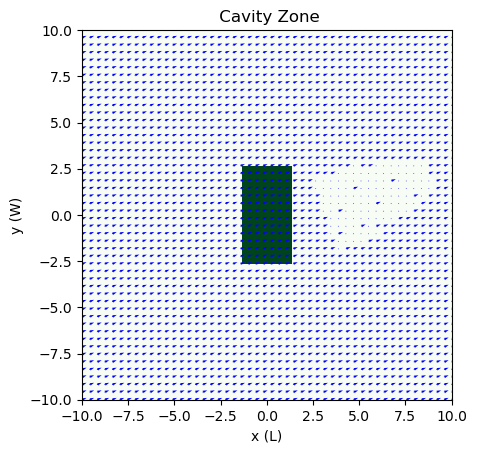

In [690]:
n = 50
grid_size = 10

x, delta = np.linspace(-grid_size, grid_size, n, retstep=True)
y = np.linspace(-grid_size, grid_size, n)
X,Y = np.meshgrid(x,y)
Z = 0.1
wind_velocity_x = 0.5
wind_velocity_y = 0.2

U = np.ones_like(X) * wind_velocity_x
V = np.ones_like(Y) * wind_velocity_y

building_pos_x = 0
building_pos_y = 0

L, W, H = 3,4,4
scale = 1

U,V = define_cavity_zone(X, Y, U, V, wind_velocity_x, wind_velocity_y, L, W, H, Z, building_pos_x, building_pos_y, delta)

plt.quiver(X, Y, U, V, scale=40, color='blue')
plt.imshow(elevation,cmap='Greens', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.xlabel('x (L)')
plt.ylabel('y (W)')
plt.title(' Cavity Zone')
plt.show()


In [691]:
bell_elevation = np.load("bell_steep_elevation.npy")

bell_elevation -= np.min(bell_elevation)


# split_elevation()

In [692]:
def split_elevation(elevation, N, plot=True):
    rows, cols = elevation.shape


    if N >= rows or N >= cols:
        N = min(rows, cols) - 1

    block_size_x = rows // N
    block_size_y = cols // N
    new_elevation = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            block = elevation[i * block_size_x:(i + 1) * block_size_x, j * block_size_y:(j + 1) * block_size_y]
            
            new_elevation[i, j] = np.mean(block)
    
    if plot:
        figure = plt.figure(figsize=(10,12))
        
        ax1 = figure.add_subplot(121)
        ax1.imshow(elevation)
        ax1.set_title("Original Elevation")
        #ax1.set_ylim(0, elevation.shape[1])
        # ax1.axis('off')
        
        ax2 = figure.add_subplot(122)
        ax2.imshow(new_elevation)
        ax2.set_title(f"Approximated Elevation, N = {N}")
        #ax2.set_ylim(0,elevation.shape[1])

        # ax2.axis("off")
        plt.show()

    return new_elevation




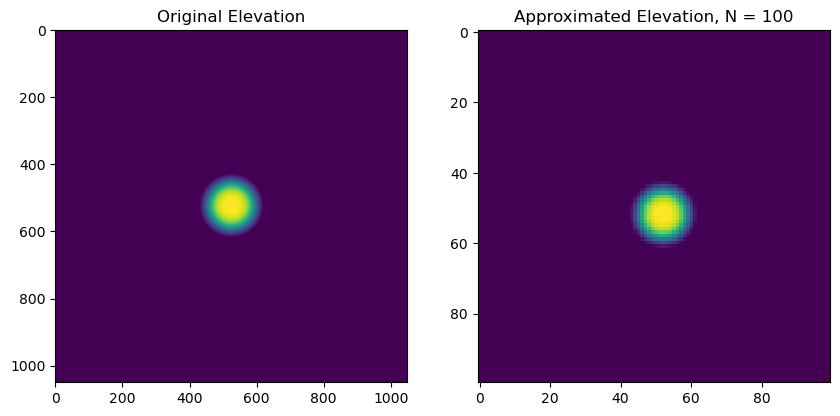

In [693]:
new_elevation = split_elevation(bell_elevation, N=100)

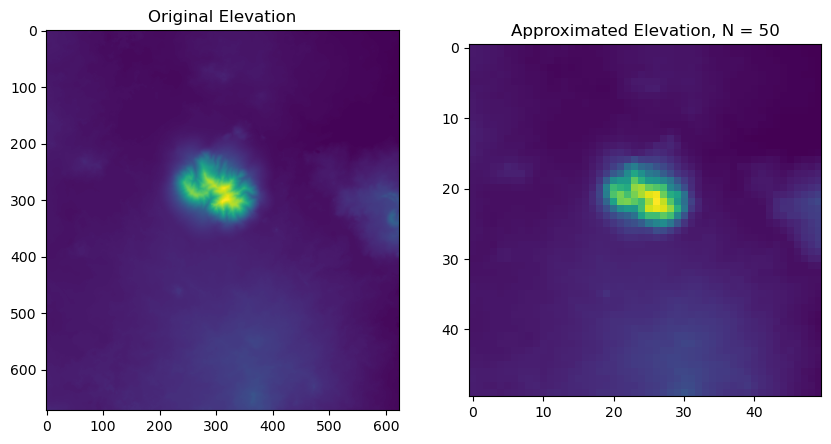

max:  785.84937


In [694]:
big_butte = np.load("big_butte.npy")
big_butte -= np.min(big_butte)
N = 50
big_butte_approx = split_elevation(big_butte, N)
print("max: ", np.max(big_butte))

# max_building_algorithm()

In [695]:
def max_building_algorithm(elevation, N, tol, scale_x, scale_y):
    visited = np.zeros((N,N), dtype=bool)
    lengths = []
    widths = []
    x_pos = []
    y_pos = []
    heights = []
    # iterate through each cell
    for j in range(N):
        for i in range(N):

            # check if it's been visited yet
            if visited[i,j]:
                continue
            else:
                # iterate along the y direction
                for k in range(i+1, N):
                    
                    if visited[k,j]:

                        break
                    if np.abs(elevation[i,j] - elevation[k,j]) < tol:
                        continue
                    else:
                        break

                for l in range(j+1, N):
                    if np.any(visited[i:k,l]):
                        break
                    if np.all(np.abs(elevation[i,j] - elevation[i:k,l]) < tol):
                        continue
                    else:
                        break

                length = (l-j) * scale_x
                lengths.append(length)
                x_pos.append(j*scale_x)
                
                width = (k-i) * scale_y
                widths.append(width)
                y_pos.append(i*scale_y)
                height = np.mean(elevation[i:k, j:l])
                heights.append(height)
        
                visited[i:k, j:l] = True
    return heights, widths, lengths, x_pos, y_pos



In [696]:
scale_x = big_butte.shape[0]/N
M = (big_butte.shape[1]*N)//big_butte.shape[0]
scale_y = big_butte.shape[1]/M

tol=5
h, w, l, x, y = max_building_algorithm(big_butte_approx, N=N, tol = tol, scale_x = scale_x, scale_y = scale_y)
max_height = np.max(big_butte)

nans = np.argwhere(np.isnan(np.array(h)))

np.array(w)
new_w = np.delete(np.array(w), nans)
new_h = np.delete(np.array(h), nans)
new_l = np.delete(np.array(l), nans)
new_x = np.delete(np.array(x), nans)
new_y = np.delete(np.array(y), nans)

zeros = np.where(new_h <= max_height/10)
new_w = np.delete(new_w, zeros)
new_h = np.delete(new_h, zeros)
new_l = np.delete(new_l, zeros)
new_x = np.delete(new_x, zeros)
new_y = np.delete(new_y, zeros)


# print("Heights:", new_h)
# print("Widths: ", new_w)
# print("Lengths: ", new_l)
# print("x position: ", new_x)
# print("y position: ", new_y)

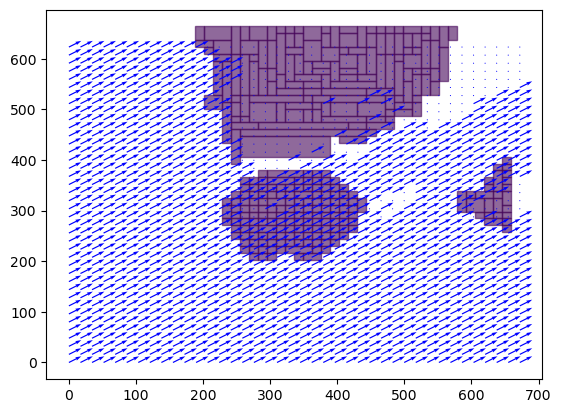

In [697]:
M = len(new_h)
num_ticks = 40

x, step = np.linspace(-big_butte.shape[0]/2, big_butte.shape[0]/2, num_ticks, retstep = True)
y = np.linspace(-big_butte.shape[1]/2, big_butte.shape[1]/2, num_ticks)
X,Y = np.meshgrid(x,y)

x_plot = np.linspace(0, big_butte.shape[0], num_ticks)
y_plot = np.linspace(0, big_butte.shape[1], num_ticks)
X_plot, Y_plot = np.meshgrid(x_plot,y_plot)

wind_velocity_x = 1.0
wind_velocity_y = 0.5
U = np.ones_like(X) * wind_velocity_x
V = np.ones_like(Y) * wind_velocity_y
Z = 1

x_pos_zero_centered = (new_x - big_butte.shape[0]/2) / step
y_pos_zero_centered = (new_y - big_butte.shape[1]/2) / step

norm = mcolors.Normalize(vmin=min(new_h), vmax=max(new_h))
cmap = plt.cm.viridis  # Choose a colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for i in range(M):
    U,V = define_cavity_zone(X, Y, U, V, wind_velocity_x, wind_velocity_y, new_l[i], new_w[i], new_h[i], Z, x_pos_zero_centered[i], y_pos_zero_centered[i], step)

# plt.imshow(big_butte)
for j in range(M):
    color = cmap(norm(new_h[i]))
    plt.gca().add_patch(plt.Rectangle((new_x[j], new_y[j]), new_l[j], new_w[j], fill=True, color=color, alpha=0.6))
plt.quiver(X_plot, Y_plot, U, V, scale=40, color='blue')

plt.show()
    

# CODE CLEANUP:

1. How do we define "close in height" buildings? Should probably be a ratio of the height difference to width or something?
2. How do we specify the lower cutoff ('zero elevation buildings')? Maybe lowest quarter height? Something like that
3. Combine all the code into a function where we can specify
    a. original elevation file
    b. N
    

# should_define_cavity_zone()

In [698]:
def should_define_cavity_zone(l, h, x_pos):
    K = len(l)
    buildings_with_cavity_zones = []

    is_downwind = np.zeros((K,K))   
    is_higher = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            if x_pos[i] + l[i] == x_pos[j]:
                is_downwind[i,j] = 1
            if h[i] > h[j]:
                is_higher[i,j] = 1
    
    cavity = is_downwind * is_higher
    for i in range(K):
        if np.any(cavity[i] == 1):
            buildings_with_cavity_zones.append(i)
    
    return buildings_with_cavity_zones


# Generalized Function Form

In [699]:
def get_cavity_zones(elevation_file, N, wind_velocity_x =1.0, wind_velocity_y = 0, min_height = 130):
    # read in the elevation file and normalize
    elevation = np.load(elevation_file)

    
    # make the elevation file into a square
    A,B = elevation.shape
    min_dimension = np.min([A,B])
    elevation = elevation[:min_dimension][:min_dimension]
    elevation -= np.min(elevation)

    # approximate with an NxN grid
    elevation_approx = split_elevation(elevation, N, plot=True)
    
    scale_x = min_dimension/N
    scale_y = min_dimension/N
    tol = 500/N

    h, w, l, x, y = max_building_algorithm(elevation_approx, N=N, tol = tol, scale_x = scale_x, scale_y = scale_y)

    nans = np.argwhere(np.isnan(np.array(h)))

    new_w = np.delete(np.array(w), nans)
    new_h = np.delete(np.array(h), nans)
    new_l = np.delete(np.array(l), nans)
    new_x = np.delete(np.array(x), nans)
    new_y = np.delete(np.array(y), nans)

    zeros = np.where(new_h <= min_height)
    new_w = np.delete(new_w, zeros)
    new_h = np.delete(new_h, zeros)
    new_l = np.delete(new_l, zeros)
    new_x = np.delete(new_x, zeros)
    new_y = np.delete(new_y, zeros)

    buildings_with_cavity_zones = should_define_cavity_zone(new_l, new_h, new_x)
    
    # define some values for getting cavity zones
    num_buildings = len(new_h)
    num_ticks = 50

    x, step = np.linspace(-min_dimension/2, min_dimension/2, num_ticks, retstep = True)
    y = np.linspace(-min_dimension/2, min_dimension/2, num_ticks)
    X,Y = np.meshgrid(x,y)

    x_plot = np.linspace(0, min_dimension, num_ticks)
    y_plot = np.linspace(0, min_dimension, num_ticks)
    X_plot, Y_plot = np.meshgrid(x_plot,y_plot)

    # define initial wind fields
    U = np.ones_like(X) * wind_velocity_x
    V = np.ones_like(Y) * wind_velocity_y
    Z = 3

    # recenter buildings
    x_pos_zero_centered = (new_x - min_dimension/2) / step
    y_pos_zero_centered = (new_y - min_dimension/2) / step

    #for i in range(num_buildings):
    for i in buildings_with_cavity_zones:
        U,V = define_cavity_zone(X, Y, U, V, wind_velocity_x, wind_velocity_y, new_l[i], new_w[i], new_h[i], Z, x_pos_zero_centered[i], y_pos_zero_centered[i], step)


    # plot the building algorithm alongside original
    norm = mcolors.Normalize(vmin=min(new_h), vmax=max(new_h))
    cmap = plt.cm.viridis

    figure = plt.figure(figsize=(10,12))

    ax1 = figure.add_subplot(121)
    ax2 = figure.add_subplot(122)
    ax2.set_aspect('equal')
    for j in range(num_buildings):
        color = cmap(norm(new_h[j]))  # Get color from colormap
        ax2.add_patch(plt.Rectangle((new_x[j], new_y[j]), new_l[j], new_w[j], color=color, fill=True))

    ax2.imshow(np.zeros_like(elevation_approx), extent=[0, min_dimension, min_dimension, 0])
    ax2.quiver(X_plot, Y_plot[::-1], U, V, scale=40, color='white')
    ax2.set_xlim(0, min_dimension)
    ax2.set_ylim(min_dimension, 0)
    ax2.set_title("Building Approximation with Cavity Zones")
    ax1.imshow(elevation,  extent=[0, min_dimension, min_dimension, 0])
    ax1.set_title("Original Elevation")
    plt.show()

    # # plot the wind cavity zones
    # plt.quiver(X_plot, Y_plot, U, V, scale=30, color='white')
    # plt.imshow(elevation_approx, extent=[0, min_dimension, min_dimension,0])
    # plt.title("Cavity Zones")
    # plt.show()

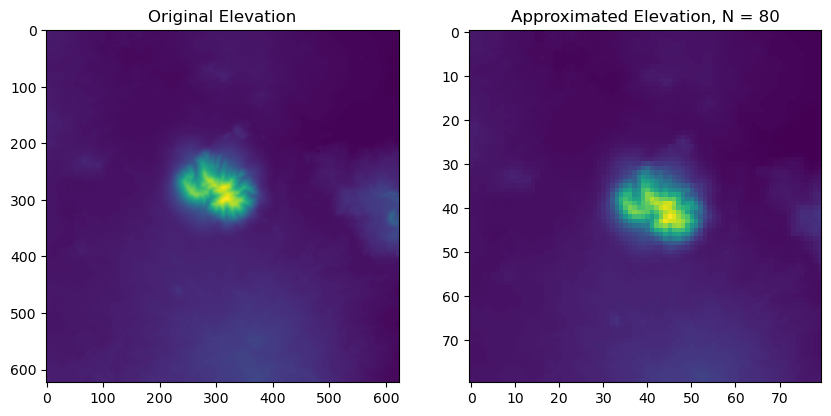

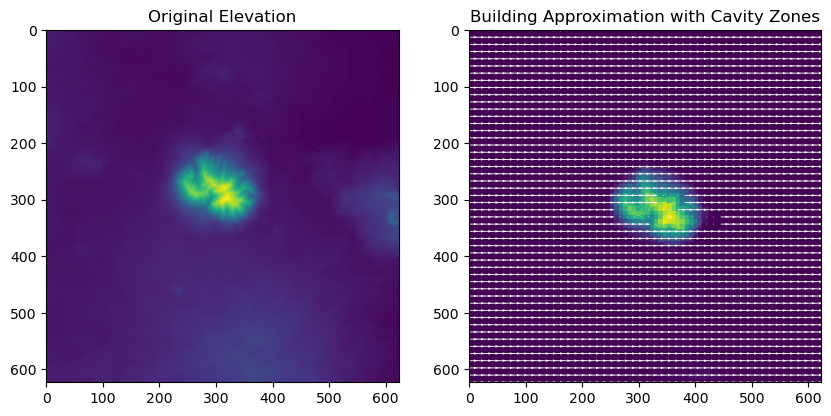

In [700]:
get_cavity_zones("big_butte.npy", 80, wind_velocity_x=1.0, wind_velocity_y=0)


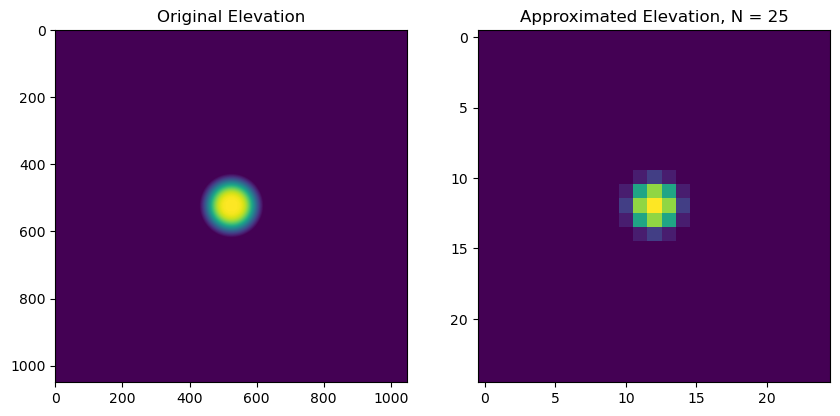

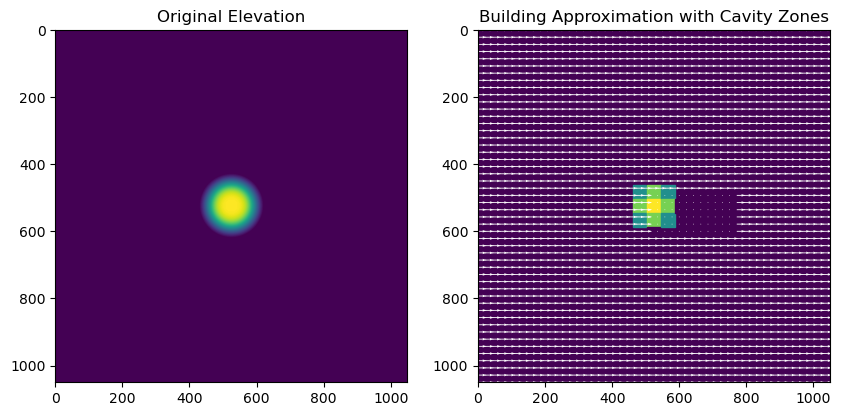

In [701]:
get_cavity_zones("bell_steep_elevation.npy", 25)

## Looking at large dataset

In [702]:
file_0 = "/Volumes/Expansion/wind_data/0/dems_folder/dem0/dem0.tif"

with rasterio.open(file_0) as src:
    elevation_0 = src.read(1)  # Reads all bands into a NumPy array

npy_path = "/Volumes/Expansion/wind_data/0/dems_folder/dem0/dem0.npy"
np.save(npy_path, elevation_0)

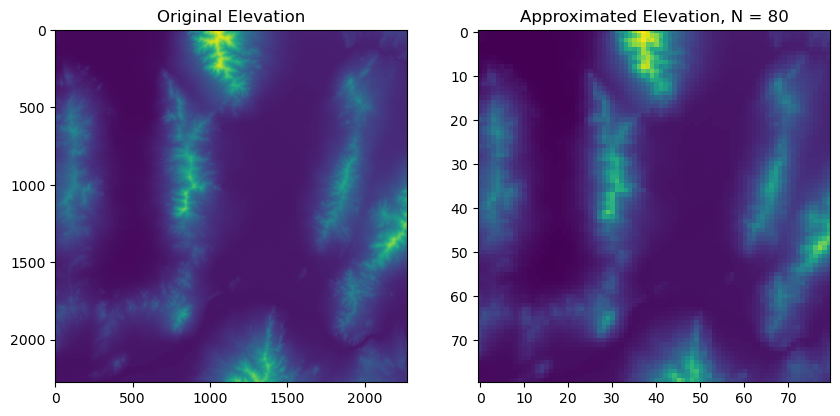

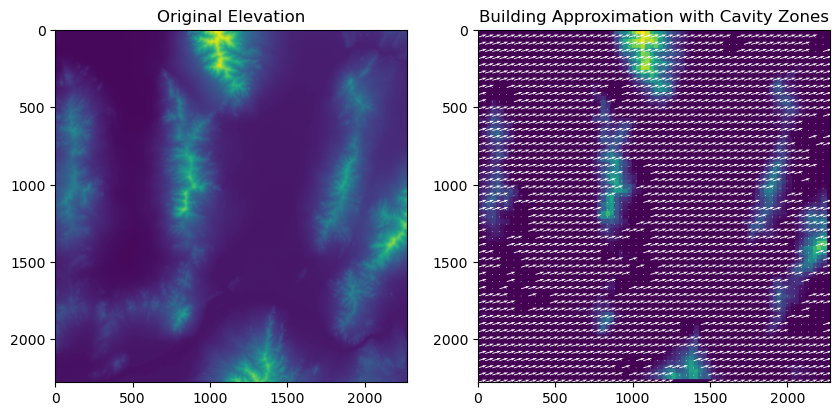

In [703]:
get_cavity_zones(npy_path, 80, wind_velocity_x=1.0, wind_velocity_y=0.3, min_height = 300)

In [704]:
file_1 = "/Volumes/Expansion/wind_data/1/dems_folder/dem0/dem0.tif"

with rasterio.open(file_1) as src:
    elevation_1 = src.read(1)  # Reads all bands into a NumPy array

npy_path = "/Volumes/Expansion/wind_data/1/dems_folder/dem0/dem0.npy"
np.save(npy_path, elevation_1)


OSError: 6022401 requested and 0 written

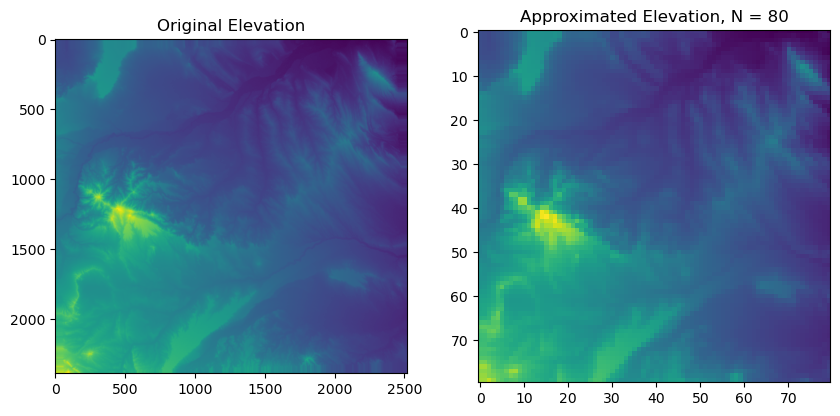

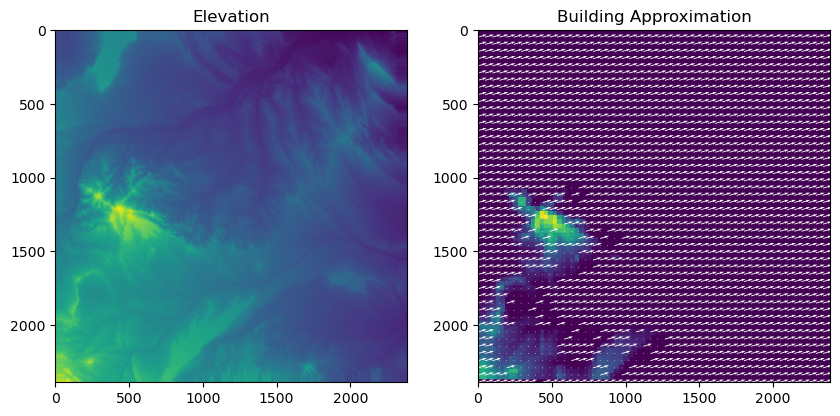

In [ ]:
get_cavity_zones(npy_path, 80, wind_velocity_x=1.0, wind_velocity_y=0.3, min_height = 450)

In [ ]:
file_3 = "/Volumes/Expansion/wind_data/3/dems_folder/dem0/dem0.tif"

with rasterio.open(file_3) as src:
    elevation_3 = src.read(1)  # Reads all bands into a NumPy array

npy_path = "/Volumes/Expansion/wind_data/3/dems_folder/dem0/dem0.npy"
np.save(npy_path, elevation_3)

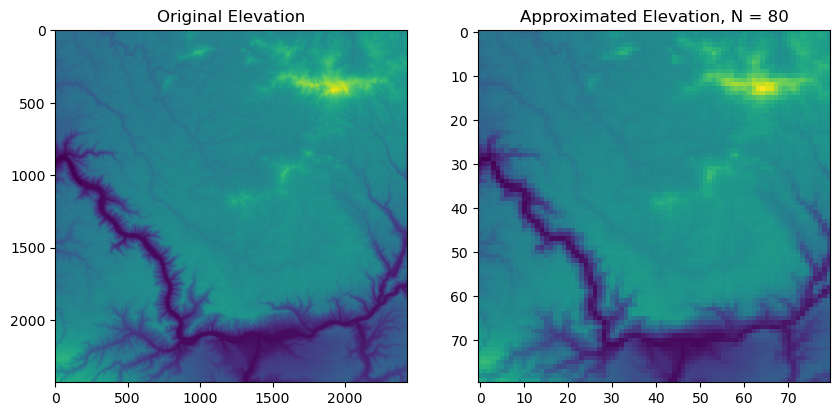

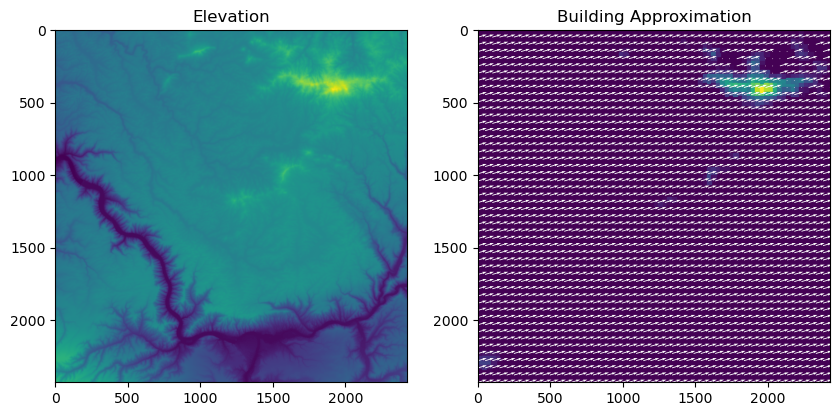

In [ ]:
get_cavity_zones(npy_path, 80, wind_velocity_x=1.0, wind_velocity_y=0.3, min_height = 750)

In [ ]:
file_5 = "/Volumes/Expansion/wind_data/5/dems_folder/dem0/dem0.tif"

with rasterio.open(file_5) as src:
    elevation_5 = src.read(1)  # Reads all bands into a NumPy array

npy_path = "/Volumes/Expansion/wind_data/5/dems_folder/dem0/dem0.npy"
np.save(npy_path, elevation_5)

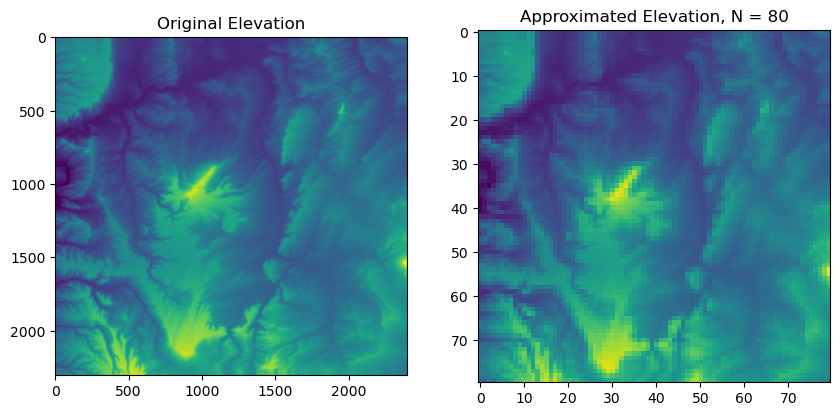

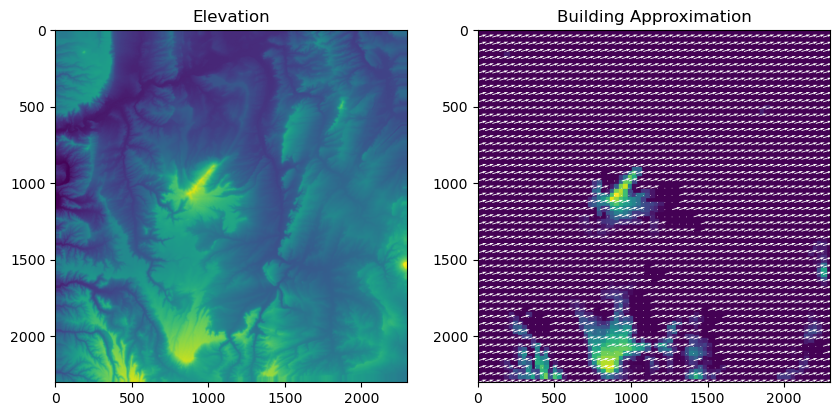

In [ ]:
get_cavity_zones(npy_path, 80, wind_velocity_x=1.0, wind_velocity_y=0.3, min_height = 475)

### Reading in Data!!

In [ ]:
# Load wind angle and velocity data
angle_file = "/Volumes/Expansion/wind_data/0/dems_folder/dem0/mass/brush/0o0deg/dem0_0_5_100m_ang.asc"
velocity_file = "/Volumes/Expansion/wind_data/0/dems_folder/dem0/mass/brush/0o0deg/dem0_0_5_100m_vel.asc"


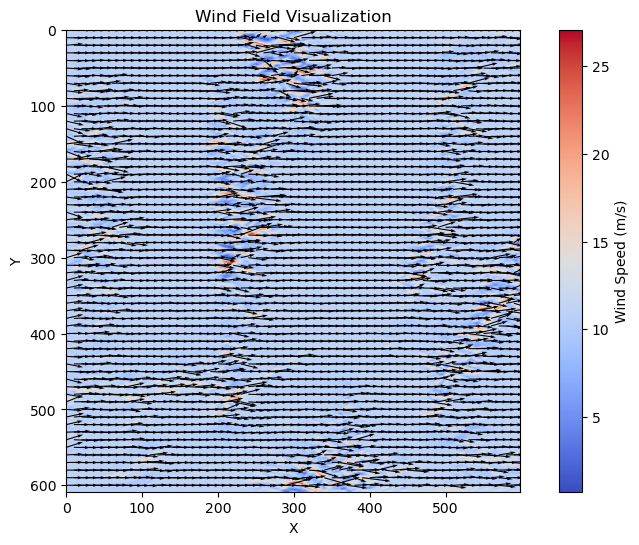

In [ ]:
with rasterio.open(angle_file) as ang_src, rasterio.open(velocity_file) as vel_src:
    angle = ang_src.read(1)  # Wind direction in degrees
    velocity = vel_src.read(1)  # Wind speed in m/s
    transform = ang_src.transform  # Georeferencing
    width, height = ang_src.width, ang_src.height  # Raster dimensions

# Convert wind direction to U, V components for quiver plot
angle_rad = np.radians(angle)  # Convert degrees to radians
U = velocity * np.cos(angle_rad)  # X component
V = velocity * np.sin(angle_rad)  # Y component

# Downsample for visualization (adjust factor for performance)
sample_factor = 10  # Change this to control arrow density
X, Y = np.meshgrid(np.arange(0, width, sample_factor), np.arange(0, height, sample_factor))
U_sampled = U[::sample_factor, ::sample_factor]
V_sampled = V[::sample_factor, ::sample_factor]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(velocity, cmap="coolwarm", origin="upper")  # Wind speed heatmap
ax.quiver(X, Y, U_sampled, -V_sampled, scale=300, color="black")  # Wind direction arrows

ax.set_title("Wind Field Visualization")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.colorbar(im, label="Wind Speed (m/s)")
plt.show()



In [ ]:
def get_mass_momentum_diff(file_number, plot=True):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/brush/0o0deg/dem0_0_5_100m_ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/brush/0o0deg/dem0_0_5_100m_vel.asc"

    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/brush/0o0deg/dem0_0_5_100m_ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/brush/0o0deg/dem0_0_5_100m_vel.asc"

    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"
    with rasterio.open(elevation_tif) as src:
        elevation = src.read(1)  # Reads all bands into a NumPy array
        elevation_npy = np.array(elevation)


    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 10  # Change this to control arrow density
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    with rasterio.open(momentum_angle_file) as ang_src_momentum, rasterio.open(momentum_vel_file) as vel_src_momentum:
        angle_momentum = ang_src_momentum.read(1)  # Wind direction in degrees
        velocity_momentum = vel_src_momentum.read(1)  # Wind speed in m/s
        transform_momentum = ang_src_momentum.transform  # Georeferencing
        width_momentum, height_momentum = ang_src_momentum.width, ang_src_momentum.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_momentum = np.radians(angle_momentum)  # Convert degrees to radians
    U_momentum = velocity_momentum * np.cos(angle_rad_momentum)  # X component
    V_momentum = velocity_momentum * np.sin(angle_rad_momentum)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 10  # Change this to control arrow density
    X_momentum, Y_momentum = np.meshgrid(np.arange(0, width_momentum, sample_factor), np.arange(0, height_momentum, sample_factor))
    U_sampled_momentum = U_momentum[::sample_factor, ::sample_factor]
    V_sampled_momentum = V_momentum[::sample_factor, ::sample_factor]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    im1 = ax1.imshow(elevation_npy,extent = [0, 620, 620, 0], cmap="coolwarm", origin="upper")  # Wind speed heatmap
    ax1.quiver(X_mass, Y_mass, U_sampled_mass, -V_sampled_mass, scale=300, color="black")  # Wind direction arrows

    ax1.set_title("Mass Solver")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    print(X_momentum[-1][-1])
    im2 = ax2.imshow(elevation_npy, extent = [0, 620, 620, 0], cmap="coolwarm", origin="upper")  # Wind speed heatmap
    ax2.quiver(X_momentum, Y_momentum, U_sampled_momentum, -V_sampled_momentum, scale=300, color="black")  # Wind direction arrows

    ax2.set_title("Momentum Solver")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")



    fig.tight_layout()
    plt.show()

    # plot the difference...
    fig = plt.figure(figsize=(10,8))
    U_diff = U_sampled_momentum - U_sampled_mass
    V_diff = V_sampled_momentum - V_sampled_mass

    print(U_diff.shape)
    print(V_diff.shape)

    plt.imshow(velocity_mass, cmap="coolwarm", origin="upper")
    plt.quiver(X_mass, Y_mass, U_diff, -V_diff, scale=300, color="black")
    plt.title("Difference")
    plt.xlabel('X')
    plt.ylabel("Y")
    plt.show()
    


In [ ]:
get_mass_momentum_diff(0)

RasterioIOError: /Volumes/Expansion/wind_data/0/dems_folder/dem0/dem0.tif: No such file or directory